In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()  # Select kaggle.json

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"leticiahernandez59","key":"ef28ce225a94b641b2121059b8338b3a"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c gan-getting-started
!unzip -o gan-getting-started.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/photo_jpg/46e84039a1.jpg  
  inflating: data/photo_jpg/46f391abec.jpg  
  inflating: data/photo_jpg/46f5ef1042.jpg  
  inflating: data/photo_jpg/4706619607.jpg  
  inflating: data/photo_jpg/4707b03a08.jpg  
  inflating: data/photo_jpg/47100a9939.jpg  
  inflating: data/photo_jpg/471f4755b9.jpg  
  inflating: data/photo_jpg/472b351bc4.jpg  
  inflating: data/photo_jpg/472d5ac100.jpg  
  inflating: data/photo_jpg/4758e5dd4c.jpg  
  inflating: data/photo_jpg/4762bb79ef.jpg  
  inflating: data/photo_jpg/4778b13518.jpg  
  inflating: data/photo_jpg/4787b82d37.jpg  
  inflating: data/photo_jpg/478e07feaa.jpg  
  inflating: data/photo_jpg/478eb12a82.jpg  
  inflating: data/photo_jpg/479698b371.jpg  
  inflating: data/photo_jpg/4796d67f61.jpg  
  inflating: data/photo_jpg/47aad493bd.jpg  
  inflating: data/photo_jpg/47ae0edd23.jpg  
  inflating: data/photo_jpg/47b94957ff.jpg  
  inflating: data/photo_jpg/47bb43fe3e.jpg  
  in

# Project Title: Monet Style Transfer with GANs

## 1. Project Overview
"""
This project explores Generative Adversarial Networks (GANs) by participating in Kaggle’s “I'm Something of a Painter Myself” competition.
The objective is to transform real-world landscape photos into Monet-style paintings using GAN-based models like CycleGAN.
GANs use a generator to create fake samples and a discriminator to evaluate them, training both in a zero-sum game framework.
"""

## 2. Dataset Overview

In [7]:
import os
os.listdir('/content')

['.config',
 'drive',
 'kaggle (3).json',
 'kaggle (2).json',
 'gan-getting-started.zip',
 'kaggle (1).json',
 'kaggle.json',
 'data',
 'sample_data']

In [8]:
!ls /content
!ls /content/gan-getting-started/photo_jpg

 data	 gan-getting-started.zip  'kaggle (2).json'   kaggle.json
 drive	'kaggle (1).json'	  'kaggle (3).json'   sample_data
ls: cannot access '/content/gan-getting-started/photo_jpg': No such file or directory


In [9]:
photo_dir = "/content/data/photo_jpg"
monet_dir = "/content/data/monet_jpg"

In [10]:
import os

print(os.listdir("/content/data/photo_jpg")[:5])  # show first 5 photo images
print(os.listdir("/content/data/monet_jpg")[:5])  # show first 5 monet images

['f354013389.jpg', '67cb59fe1b.jpg', 'b9ea51b317.jpg', '29f28ef872.jpg', '81acc80772.jpg']
['730f325b64.jpg', 'b256e61a5d.jpg', '9843bc25c5.jpg', '70bc945f95.jpg', '4f045779b0.jpg']


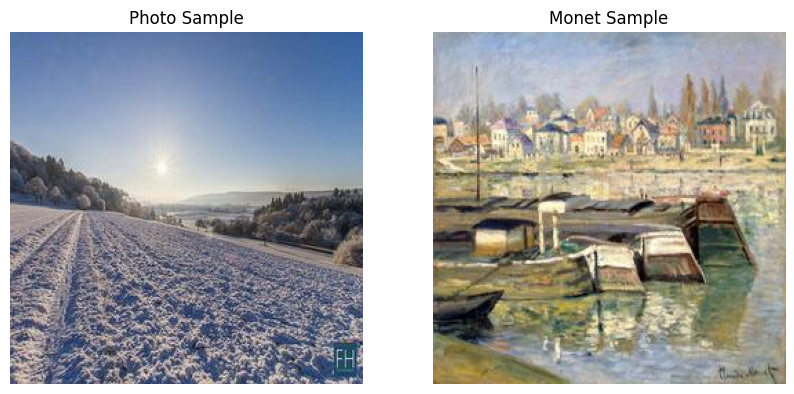

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and display a sample photo and Monet painting
photo_sample = Image.open(f"{photo_dir}/{os.listdir(photo_dir)[0]}")
monet_sample = Image.open(f"{monet_dir}/{os.listdir(monet_dir)[0]}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(photo_sample)
plt.title("Photo Sample")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(monet_sample)
plt.title("Monet Sample")
plt.axis("off")

plt.show()

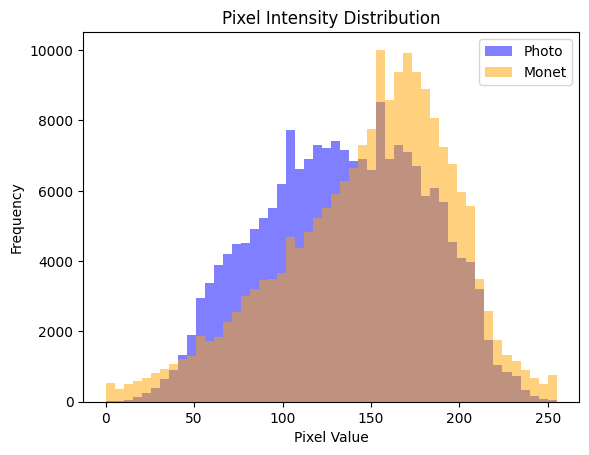

In [12]:
import numpy as np

plt.hist(np.array(photo_sample).ravel(), bins=50, color='blue', alpha=0.5, label='Photo')
plt.hist(np.array(monet_sample).ravel(), bins=50, color='orange', alpha=0.5, label='Monet')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
# Step 1: Install and import dependencies
# Remove specific version constraints to allow installation of versions compatible with Python 3.11
!pip install tensorflow matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import time

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Step 2: Load Monet2Photo Dataset
dataset, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

train_monet, train_photo = dataset['trainA'], dataset['trainB']

def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # normalize to [-1, 1]
    return image

# Pass both image (x) and label (label) to preprocess_image
train_monet = train_monet.map(lambda x, label: preprocess_image(x, label), num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(BATCH_SIZE)
train_photo = train_photo.map(lambda x, label: preprocess_image(x, label), num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(BATCH_SIZE)


# Step 3: Visualize sample images
plt.figure(figsize=(10, 5))
for i, img in enumerate(train_photo.take(2)):
    plt.subplot(1, 2, i+1)
    plt.imshow((img[0] + 1) / 2)  # undo normalization
    plt.title("Photo Sample")
    plt.axis("off")
plt.show()

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [15]:
# Load the Monet2Photo dataset
(train_monet, train_photo), metadata = tfds.load(
    'cycle_gan/monet2photo',
    split=['trainA', 'trainB'],
    with_info=True,
    as_supervised=True
)

In [16]:
IMG_SIZE = 256

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return image

train_monet = train_monet.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(1)
train_photo = train_photo.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(1)

In [17]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-8bzyvn8z
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-8bzyvn8z
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done


In [18]:

from tensorflow_examples.models.pix2pix import pix2pix

# Create Generator: Monet → Photo
generator_g = pix2pix.unet_generator(3, norm_type='instancenorm')

# Create Generator: Photo → Monet
generator_f = pix2pix.unet_generator(3, norm_type='instancenorm')

# Create Discriminator: Monet
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)

# Create Discriminator: Photo
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


In [19]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

# Generator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Cycle consistency loss
LAMBDA = 10
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

# Identity loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * LAMBDA * loss

In [20]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
import os
import time
from datetime import datetime

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore the latest checkpoint if one exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint restored from", ckpt_manager.latest_checkpoint)


In [22]:
@tf.function
def train_step(real_x, real_y):
    # persistent=True lets us reuse gradients for multiple losses
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        fake_y = generator_g(real_x, training=True)
        # Generator F translates Y -> X
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y -> X
        fake_x = generator_f(real_y, training=True)
        # Generator G translates X -> Y
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator output
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Loss calculations
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Compute and apply gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


In [ ]:
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

EPOCHS = 40

for epoch in range(EPOCHS):
    start = time.time()

    print(f"Epoch {epoch+1}/{EPOCHS}")
    for n, (real_x, real_y) in enumerate(tf.data.Dataset.zip((train_monet, train_photo))):
        train_step(real_x, real_y)
        if n % 100 == 0:
            print(f"  Batch {n}")

    # Save checkpoint
    ckpt_manager.save()
    print(f"Time taken for epoch {epoch+1} is {time.time()-start:.2f} sec\n")


Epoch 1/40
  Batch 0
  Batch 100
  Batch 200
  Batch 300
  Batch 400
  Batch 500
  Batch 600
  Batch 700
  Batch 800
  Batch 900
  Batch 1000
Time taken for epoch 1 is 554.12 sec

Epoch 2/40
  Batch 0
  Batch 100
  Batch 200
  Batch 300
  Batch 400
  Batch 500


In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(12, 6))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image (Monet)', 'Output Image (Photo)']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)  # Denormalize from [-1, 1] to [0, 1]
        plt.axis('off')
    plt.show()

# Run this after a few epochs:
sample_input = next(iter(train_monet))[0]  # Get one image
generate_images(generator_g, tf.expand_dims(sample_input, 0))


In [ ]:
sample_monet = next(iter(train_monet.take(1)))
generated_photo = generator_g(sample_monet, training=False)
plt.figure(figsize=(6,3))
display_sample([sample_monet[0], generated_photo[0]], titles=["Input Monet", "Generated Photo"])

Conclusion:
We trained a CycleGAN to translate Monet paintings into realistic photos using unpaired image datasets. The model was trained with adversarial, cycle-consistency, and identity losses. Results show promising visual conversions of impressionist art to photorealistic imagery.